# Let's train a Nerfie!

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://nerfies.github.io)]
[[Paper](https://storage.googleapis.com/nerfies-public/videos/nerfies_paper.pdf)]
[[Video](https://www.youtube.com/watch?v=MrKrnHhk8IA)]
[[GitHub](https://github.com/google/nerfies)]

This notebook provides an demo for training Nerfies.

### Instructions

1. Convert a video into our dataset format using the [dataset processing notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Capture_Processing.ipynb).
2. Set the `data_dir` below to where you saved the dataset.
3. Come back to this notebook to train a nerfie.


### Notes
 * To accomodate the limited compute power of Colab runtimes, this notebook defaults to a "toy" version of our method. The number of samples have been reduced and the elastic regularization turned off.

 * To train a high-quality model, please look at the CLI options we provide in the [Github repository](https://github.com/google/nerfies).



 * Please report issues on the [GitHub issue tracker](https://github.com/google/nerfies/issues).


If you find this work useful, please consider citing:
```bibtex
@article{park2020nerfies
  author    = {Park, Keunhong 
               and Sinha, Utkarsh 
               and Barron, Jonathan T. 
               and Bouaziz, Sofien 
               and Goldman, Dan B 
               and Seitz, Steven M. 
               and Martin-Brualla, Ricardo},
  title     = {Deformable Neural Radiance Fields},
  journal   = {arXiv preprint arXiv:2011.12948},
  year      = {2020},
}
```


## Environment Setup

In [1]:
!pip install flax frozendict ipyplot
!pip install git+https://github.com/google/nerfies

  Cloning https://github.com/google/nerfies to /tmp/pip-req-build-gcabav0q
  Running command git clone -q https://github.com/google/nerfies /tmp/pip-req-build-gcabav0q


In [2]:
!pip install --upgrade jax jaxlib==0.1.62+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html


In [2]:
# @title Configure notebook runtime
# @markdown If you would like to use a GPU runtime instead, change the runtime type by going to `Runtime > Change runtime type`. 
# @markdown You will have to use a smaller batch size on GPU.
import jax

runtime_type = 'gpu'  # @param ['gpu', 'tpu']
# if runtime_type == 'tpu':
#   import jax.tools.colab_tpu
#   jax.tools.colab_tpu.setup_tpu()

print('Detected Devices:', jax.devices())

Detected Devices: [GpuDevice(id=0)]


In [4]:
# @title Mount Google Drive
# @markdown Mount Google Drive onto `/content/gdrive`. You can skip this if running locally.

# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# @title Define imports and utility functions.

import jax
from jax.config import config as jax_config
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import flax
import flax.linen as nn
from flax import jax_utils
from flax import optim
from flax.metrics import tensorboard
from flax.training import checkpoints
jax_config.enable_omnistaging() # Linen requires enabling omnistaging

from absl import logging
from io import BytesIO
import random as pyrandom
import numpy as np
import PIL
import IPython


# Monkey patch logging.
def myprint(msg, *args, **kwargs):
 print(msg % args)

logging.info = myprint 
logging.warn = myprint
logging.error = myprint


def show_image(image, fmt='png'):
    image = image_utils.image_to_uint8(image)
    f = BytesIO()
    PIL.Image.fromarray(image).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))



In [7]:
!pip install gin-config

     |████████████████████████████████| 46 kB 3.7 MB/s eta 0:00:011


## Configuration

In [13]:
# @title Model and dataset configuration

from pathlib import Path
from pprint import pprint
import gin
from IPython.display import display, Markdown

from nerfies import configs


# @markdown The working directory.
train_dir = './shiba/exp1'  # @param {type: "string"}
# @markdown The directory to the dataset capture.
data_dir = './shiba'  # @param {type: "string"}

# @markdown Training configuration.
max_steps = 300000  # @param {type: 'number'}
batch_size = 1024  # @param {type: 'number'}
image_scale = 1  # @param {type: 'number'}

# @markdown Model configuration.
use_viewdirs = True  #@param {type: 'boolean'}
use_appearance_metadata = True  #@param {type: 'boolean'}
warp_field_type = 'se3'  #@param['se3', 'translation']
num_warp_freqs = 8  #@param{type:'number'}
num_coarse_samples = 64  # @param {type: 'number'}
num_fine_samples = 128  # @param {type: 'number'}

checkpoint_dir = Path(train_dir, 'checkpoints')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

config_str = f"""
ExperimentConfig.image_scale = {image_scale}
ExperimentConfig.datasource_spec = {{
    'type': 'nerfies',
    'data_dir': '{data_dir}',
    'camera_type': 'json',
}}

ModelConfig.use_warp = True
ModelConfig.use_viewdirs = {int(use_viewdirs)}
ModelConfig.use_appearance_metadata = {int(use_appearance_metadata)}
ModelConfig.warp_field_type = 'se3'
ModelConfig.num_warp_freqs = {num_warp_freqs}
ModelConfig.num_coarse_samples = {num_coarse_samples}
ModelConfig.num_fine_samples = {num_fine_samples}

TrainConfig.max_steps = {max_steps}
TrainConfig.batch_size = {batch_size}
TrainConfig.print_every = 100
TrainConfig.use_elastic_loss = False
TrainConfig.use_background_loss = False
TrainConfig.warp_alpha_schedule = {{
    'type': 'linear',
    'initial_value': 0.0,
    'final_value': {num_warp_freqs},
    'num_steps': {int(max_steps*0.8)},
}}
"""

gin.parse_config(config_str)

config_path = Path(train_dir, 'config.gin')
with open(config_path, 'w') as f:
  logging.info('Saving config to %s', config_path)
  f.write(config_str)

exp_config = configs.ExperimentConfig()
model_config = configs.ModelConfig()
train_config = configs.TrainConfig()
eval_config = configs.EvalConfig()

display(Markdown(
    gin.config.markdownify_operative_config_str(gin.operative_config_str())))

Saving config to shiba/exp1/config.gin


#### Parameters for ConstantSchedule:

    # None.
    
#### Parameters for EvalConfig:

    EvalConfig.chunk = 8192
    EvalConfig.eval_once = False
    EvalConfig.num_test_eval = 10
    EvalConfig.num_train_eval = 10
    EvalConfig.num_val_eval = None
    EvalConfig.save_output = True
    
#### Parameters for ExperimentConfig:

    ExperimentConfig.datasource_spec = \
        {'camera_type': 'json', 'data_dir': './shiba', 'type': 'nerfies'}
    ExperimentConfig.datasource_type = 'nerfies'
    ExperimentConfig.image_scale = 1
    ExperimentConfig.random_seed = 12345
    ExperimentConfig.subname = None
    
#### Parameters for ExponentialSchedule:

    ExponentialSchedule.eps = 1e-10
    
#### Parameters for LinearSchedule:

    # None.
    
#### Parameters for ModelConfig:

    ModelConfig.alpha_channels = 1
    ModelConfig.appearance_metadata_dims = 8
    ModelConfig.camera_metadata_dims = 2
    ModelConfig.nerf_condition_depth = 1
    ModelConfig.nerf_condition_width = 128
    ModelConfig.nerf_skips = (4,)
    ModelConfig.nerf_trunk_depth = 8
    ModelConfig.nerf_trunk_width = 256
    ModelConfig.noise_std = None
    ModelConfig.num_coarse_samples = 64
    ModelConfig.num_fine_samples = 128
    ModelConfig.num_nerf_point_freqs = 10
    ModelConfig.num_nerf_viewdir_freqs = 4
    ModelConfig.num_warp_features = 8
    ModelConfig.num_warp_freqs = 8
    ModelConfig.rgb_channels = 3
    ModelConfig.use_appearance_metadata = 1
    ModelConfig.use_camera_metadata = False
    ModelConfig.use_linear_disparity = False
    ModelConfig.use_sample_at_infinity = True
    ModelConfig.use_stratified_sampling = True
    ModelConfig.use_viewdirs = 1
    ModelConfig.use_warp = True
    ModelConfig.use_white_background = False
    ModelConfig.warp_field_type = 'se3'
    
#### Parameters for TrainConfig:

    TrainConfig.background_loss_weight = 0.0
    TrainConfig.background_points_batch_size = 16384
    TrainConfig.batch_size = 1024
    TrainConfig.elastic_loss_weight_schedule = ('constant', 0.0)
    TrainConfig.elastic_reduce_method = 'weight'
    TrainConfig.log_every = 100
    TrainConfig.max_steps = 300000
    TrainConfig.print_every = 100
    TrainConfig.save_every = 10000
    TrainConfig.use_background_loss = False
    TrainConfig.use_elastic_loss = False
    TrainConfig.warp_alpha_schedule = \
        {'final_value': 8,
         'initial_value': 0.0,
         'num_steps': 240000,
         'type': 'linear'}

*** Loading dataset IDs from shiba/dataset.json


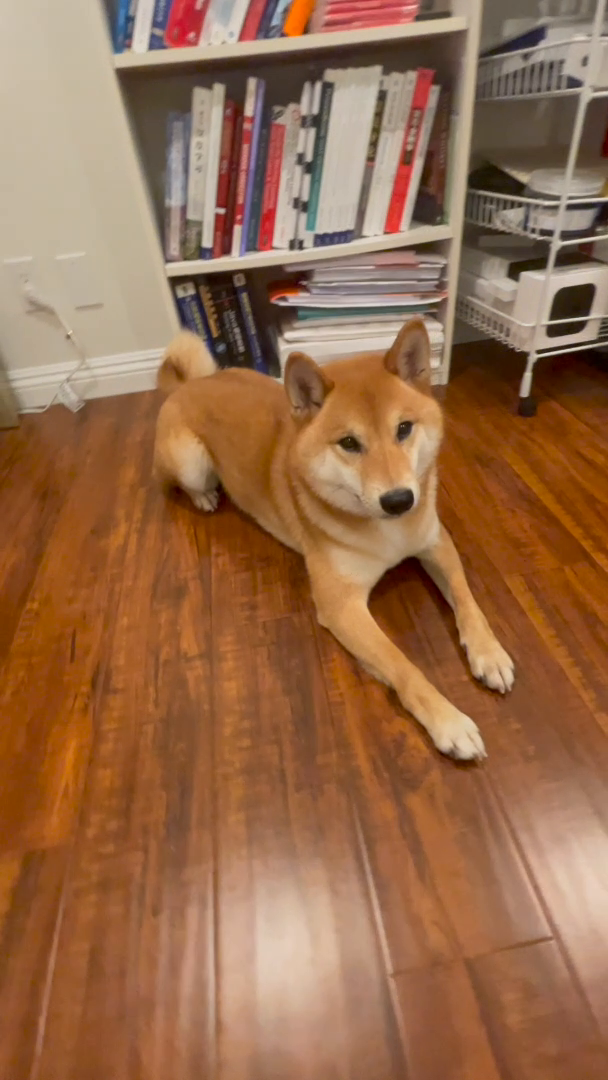

In [5]:
# @title Create datasource and show an example.

from nerfies import datasets
from nerfies import image_utils

datasource = datasets.from_config(
  exp_config.datasource_spec,
  image_scale=exp_config.image_scale,
  use_appearance_id=model_config.use_appearance_metadata,
  use_camera_id=model_config.use_camera_metadata,
  use_warp_id=model_config.use_warp,
  random_seed=exp_config.random_seed)

show_image(datasource.load_rgb(datasource.train_ids[0]))

In [6]:
# @title Create training iterators

devices = jax.local_devices()

train_iter = datasource.create_iterator(
    datasource.train_ids,
    batch_size=train_config.batch_size,
    flatten=True,
    shuffle=True,
    prefetch_size=3,
    devices=devices)

def shuffled(l):
  import random as r
  import copy
  l = copy.copy(l)
  r.shuffle(l)
  return l

train_eval_iter = datasource.create_iterator(
    shuffled(datasource.train_ids), batch_size=0, devices=devices)
val_eval_iter = datasource.create_iterator(
    shuffled(datasource.val_ids), batch_size=0, devices=devices)

*** Creating a dataset with 79 items.
	Loaded item 000014: shape=(1080, 608, 3), scale_factor=1.000000, metadata={'appearance': 10, 'warp': 10}
	Loaded item 000004: shape=(1080, 608, 3), scale_factor=1.000000, metadata={'appearance': 0, 'warp': 0}
	Loaded item 000016: shape=(1080, 608, 3), scale_factor=1.000000, metadata={'appearance': 12, 'warp': 12}
	Loaded item 000039: shape=(1080, 608, 3), scale_factor=1.000000, metadata={'appearance': 34, 'warp': 34}
	Loaded item 000034: shape=(1080, 608, 3), scale_factor=1.000000, metadata={'appearance': 29, 'warp': 29}
	Loaded item 000033: shape=(1080, 608, 3), scale_factor=1.000000, metadata={'appearance': 28, 'warp': 28}
	Loaded item 000044: shape=(1080, 608, 3), scale_factor=1.000000, metadata={'appearance': 38, 'warp': 38}
	Loaded item 000028: shape=(1080, 608, 3), scale_factor=1.000000, metadata={'appearance': 23, 'warp': 23}	Loaded item 000022: shape=(1080, 608, 3), scale_factor=1.000000, metadata={'appearance': 18, 'warp': 18}

	Loaded it

## Training

In [14]:
# @title Initialize model
# @markdown Defines the model and initializes its parameters.

from flax.training import checkpoints
from nerfies import models
from nerfies import model_utils
from nerfies import schedules
from nerfies import training

# @markdown Restore a checkpoint if one exists.
restore_checkpoint = True  # @param{type:'boolean'}


rng = random.PRNGKey(exp_config.random_seed)
np.random.seed(exp_config.random_seed + jax.host_id())
devices_to_use = jax.devices()

learning_rate_sched = schedules.from_config(train_config.lr_schedule)
warp_alpha_sched = schedules.from_config(train_config.warp_alpha_schedule)
elastic_loss_weight_sched = schedules.from_config(
    train_config.elastic_loss_weight_schedule)

rng, key = random.split(rng)
params = {}
model, params['model'] = models.nerf(
    key,
    model_config,
    batch_size=train_config.batch_size,
    num_appearance_embeddings=len(datasource.appearance_ids),
    num_camera_embeddings=len(datasource.camera_ids),
    num_warp_embeddings=len(datasource.warp_ids),
    near=datasource.near,
    far=datasource.far,
    use_warp_jacobian=train_config.use_elastic_loss,
    use_weights=train_config.use_elastic_loss)

optimizer_def = optim.Adam(learning_rate_sched(0))
optimizer = optimizer_def.create(params)
state = model_utils.TrainState(
    optimizer=optimizer,
    warp_alpha=warp_alpha_sched(0))
scalar_params = training.ScalarParams(
    learning_rate=learning_rate_sched(0),
    elastic_loss_weight=elastic_loss_weight_sched(0),
    background_loss_weight=train_config.background_loss_weight)
if restore_checkpoint:
  logging.info('Restoring checkpoint from %s', checkpoint_dir)
  state = checkpoints.restore_checkpoint(checkpoint_dir, state)
step = state.optimizer.state.step + 1
state = jax_utils.replicate(state, devices=devices)
del params

Restoring checkpoint from shiba/exp1/checkpoints
Restoring checkpoint from shiba/exp1/checkpoints/checkpoint_193000


In [15]:
# @title Define pmapped functions
# @markdown This parallelizes the training and evaluation step functions using `jax.pmap`.

import functools
from nerfies import evaluation


def _model_fn(key_0, key_1, params, rays_dict, alpha):
  out = model.apply({'params': params},
                    rays_dict,
                    warp_alpha=alpha,
                    rngs={
                        'coarse': key_0,
                        'fine': key_1
                    },
                    mutable=False)
  return jax.lax.all_gather(out, axis_name='batch')

pmodel_fn = jax.pmap(
    # Note rng_keys are useless in eval mode since there's no randomness.
    _model_fn,
    # key0, key1, params, rays_dict, alpha
    in_axes=(0, 0, 0, 0, 0),
    devices=devices,
    donate_argnums=(3,),  # Donate the 'rays' argument.
    axis_name='batch',
)

render_fn = functools.partial(evaluation.render_image,
                              model_fn=pmodel_fn,
                              device_count=len(devices),
                              chunk=eval_config.chunk)

train_step = functools.partial(
    training.train_step,
    model,
    elastic_reduce_method=train_config.elastic_reduce_method,
    use_elastic_loss=train_config.use_elastic_loss,
    use_background_loss=train_config.use_background_loss)
ptrain_step = jax.pmap(
    train_step,
    axis_name='batch',
    devices=devices,
    # rng_key, state, batch, scalar_params.
    in_axes=(0, 0, 0, None),
    # Treat use_elastic_loss as compile-time static.
    donate_argnums=(2,),  # Donate the 'batch' argument.
)

Starting training
step=194000, warp_alpha=6.4667, data=0.0055, total=0.1280, train_step=0.1208, steps_per_sec=7.8143
	coarse metrics: loss/rgb=0.0007, loss/total=0.0007, metric/psnr=31.6467
	fine metrics: loss/rgb=0.0005, loss/total=0.0005, metric/psnr=32.6216
[step=194000] Training set visualization
	Rendering ray batch: 0/656640
	Rendering ray batch: 8192/656640
	Rendering ray batch: 16384/656640
	Rendering ray batch: 24576/656640
	Rendering ray batch: 32768/656640
	Rendering ray batch: 40960/656640
	Rendering ray batch: 49152/656640
	Rendering ray batch: 57344/656640
	Rendering ray batch: 65536/656640
	Rendering ray batch: 73728/656640
	Rendering ray batch: 81920/656640
	Rendering ray batch: 90112/656640
	Rendering ray batch: 98304/656640
	Rendering ray batch: 106496/656640
	Rendering ray batch: 114688/656640
	Rendering ray batch: 122880/656640
	Rendering ray batch: 131072/656640
	Rendering ray batch: 139264/656640
	Rendering ray batch: 147456/656640
	Rendering ray batch: 155648/656


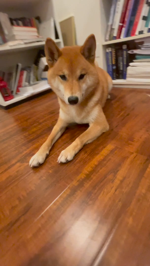
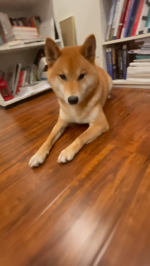
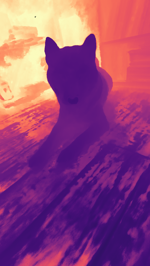


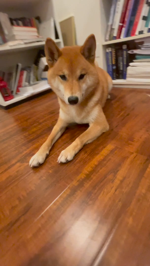
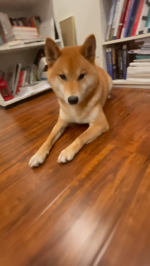
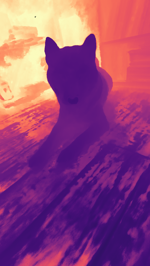

[step=194000] Validation set visualization
	Rendering ray batch: 0/656640
	Rendering ray batch: 8192/656640
	Rendering ray batch: 16384/656640
	Rendering ray batch: 24576/656640
	Rendering ray batch: 32768/656640
	Rendering ray batch: 40960/656640
	Rendering ray batch: 49152/656640
	Rendering ray batch: 57344/656640
	Rendering ray batch: 65536/656640
	Rendering ray batch: 73728/656640
	Rendering ray batch: 81920/656640
	Rendering ray batch: 90112/656640
	Rendering ray batch: 98304/656640
	Rendering ray batch: 106496/656640
	Rendering ray batch: 114688/656640
	Rendering ray batch: 122880/656640
	Rendering ray batch: 131072/656640
	Rendering ray batch: 139264/656640
	Rendering ray batch: 147456/656640
	Rendering ray batch: 155648/656640
	Rendering ray batch: 163840/656640
	Rendering ray batch: 172032/656640
	Rendering ray batch: 180224/656640
	Rendering ray batch: 188416/656640
	Rendering ray batch: 196608/656640
	Rendering ray batch: 204800/656640
	Rendering ray batch: 212992/656640
	Re

In [ ]:
# @title Train a Nerfie!
# @markdown This runs the training loop!

import ipyplot
from nerfies import utils
from nerfies import visualization as viz


print_every_n_iterations = 1000  # @param{type:'number'}
visualize_results_every_n_iterations = 1000  # @param{type:'number'}
save_checkpoint_every_n_iterations = 1000  # @param{type:'number'}


logging.info('Starting training')
rng = rng + jax.host_id()  # Make random seed separate across hosts.
keys = random.split(rng, len(devices))
time_tracker = utils.TimeTracker()
time_tracker.tic('data', 'total')

for step, batch in zip(range(step, train_config.max_steps + 1), train_iter):
  time_tracker.toc('data')
  scalar_params = scalar_params.replace(
      learning_rate=learning_rate_sched(step),
      elastic_loss_weight=elastic_loss_weight_sched(step))
  warp_alpha = jax_utils.replicate(warp_alpha_sched(step), devices)
  state = state.replace(warp_alpha=warp_alpha)

  with time_tracker.record_time('train_step'):
    state, stats, keys = ptrain_step(keys, state, batch, scalar_params)
    time_tracker.toc('total')

  if step % print_every_n_iterations == 0:
    logging.info(
        'step=%d, warp_alpha=%.04f, %s',
        step, warp_alpha_sched(step), time_tracker.summary_str('last'))
    coarse_metrics_str = ', '.join(
        [f'{k}={v.mean():.04f}' for k, v in stats['coarse'].items()])
    fine_metrics_str = ', '.join(
        [f'{k}={v.mean():.04f}' for k, v in stats['fine'].items()])
    logging.info('\tcoarse metrics: %s', coarse_metrics_str)
    if 'fine' in stats:
      logging.info('\tfine metrics: %s', fine_metrics_str)
  
  if step % visualize_results_every_n_iterations == 0:
    print(f'[step={step}] Training set visualization')
    eval_batch = next(train_eval_iter)
    rgb, depth_exp, depth_med, acc = render_fn(state, eval_batch, rng=rng)
    rgb_target = eval_batch['rgb']
    depth_med_viz = viz.colorize(depth_med[..., 0], cmin=datasource.near, cmax=datasource.far)
    ipyplot.plot_images([rgb_target, rgb, depth_med_viz],
                        ['GT RGB', 'Pred RGB', 'Pred Depth'])

    print(f'[step={step}] Validation set visualization')
    eval_batch = next(val_eval_iter)
    rgb, depth_exp, depth_med, acc = render_fn(state, eval_batch, rng=rng)
    rgb_target = eval_batch['rgb']
    depth_med_viz = viz.colorize(depth_med[..., 0], cmin=datasource.near, cmax=datasource.far)
    ipyplot.plot_images([rgb_target, rgb, depth_med_viz],
                         ['GT RGB', 'Pred RGB', 'Pred Depth'])

  if step % save_checkpoint_every_n_iterations == 0:
    training.save_checkpoint(checkpoint_dir, state)

  time_tracker.tic('data', 'total')
